In [1]:
import random
from typing import Union, List, Tuple
import numpy as np
import pandas as pd
import cv2
import librosa

from midiutil import MIDIFile
from pedalboard import Pedalboard, Chorus, Reverb
from pedalboard.io import AudioFile

from matplotlib import cm
from matplotlib import pyplot as plt
from IPython import display

In [2]:
IMAGE_PATH = "../images/Warren-Buffett-On-Rules.jpg"

### Load the image

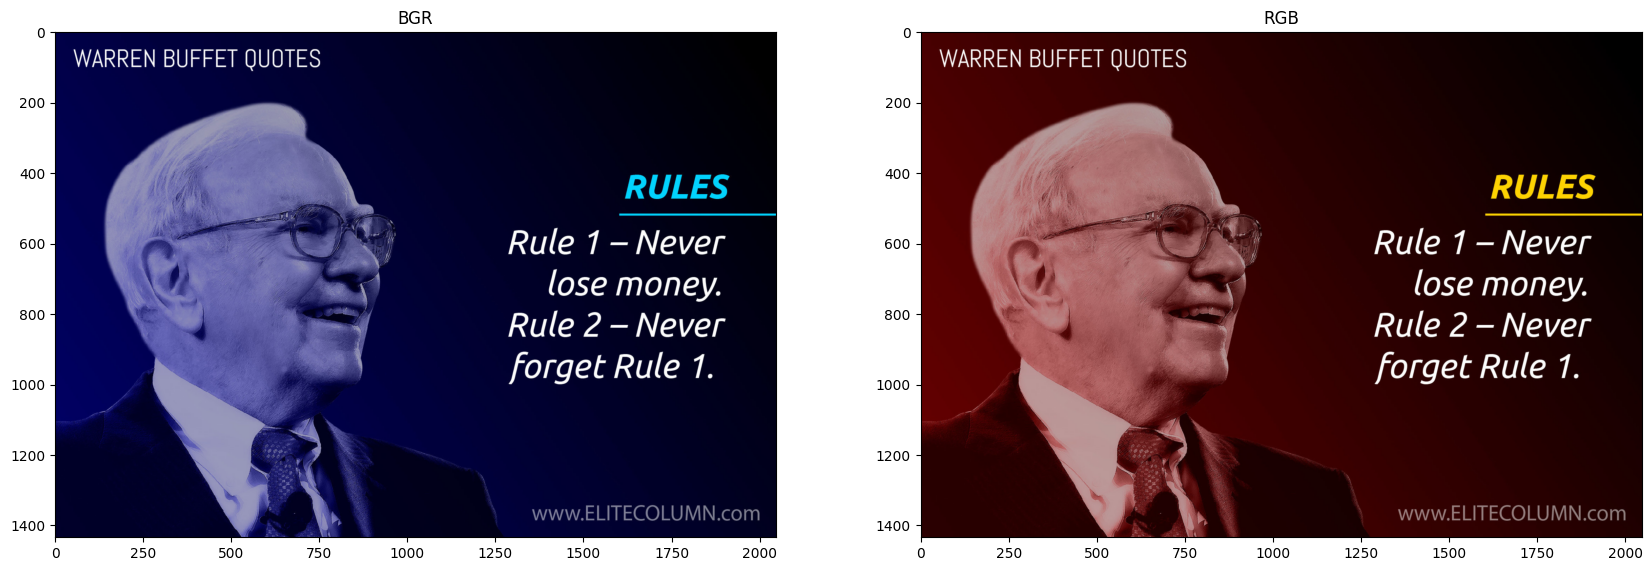

       Image Properties       
DPI(dots per inch) used for pyplot=  100.0
Height = 1434    	Width = 2048
Number of pixels in image =  2936832


In [3]:
original_img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# shape of the image
height, width, depth = img.shape
dpi = plt.rcParams['figure.dpi']
figsize = width  / float(dpi), height / float(dpi)

# Plot the image
fig, axs = plt.subplots(1, 2, figsize=figsize)
axs[0].title.set_text('BGR')
axs[0].imshow(original_img)
axs[1].title.set_text('RGB')
axs[1].imshow(img)
plt.show()

print('Image Properties'.center(30, ' '))
print("DPI(dots per inch) used for pyplot= ", dpi)
print(f'Height = {height}    \tWidth = {width}')
print('Number of pixels in image = ', height * width)

# Convert the Image to HSV
HSV stands for Hue, Saturation, and Value, which are the three components that describe a color:

- **Hue**: Represents the color type (e.g., red, green, blue).
- **Saturation**: Indicates the intensity or purity of the color (from grayscale to full color).
- **Value**: Refers to the brightness of the color (from black to full brightness).

HSV is often preferred in image processing tasks because it separates the color information (hue) from the intensity (value), making it easier to manipulate and analyze colors.

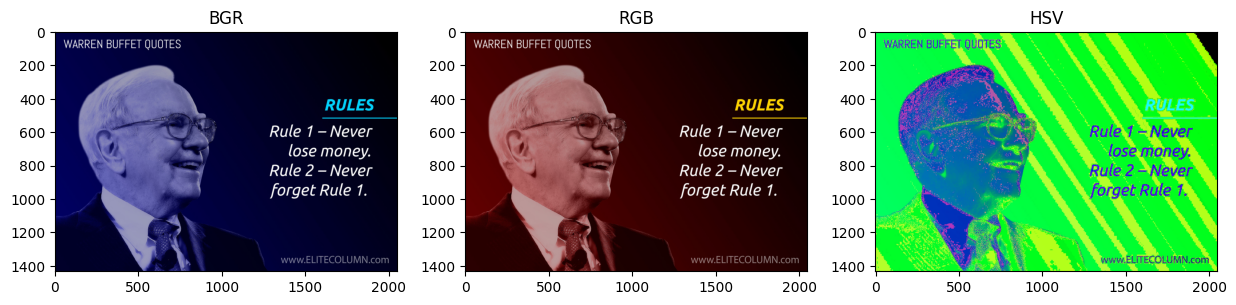

In [4]:
# need function that reads pixel hue value
hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

# plot the image
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
names = ['BGR', 'RGB', 'HSV']
images = [original_img, img, hsv_img]
i = 0
for elem in images:
    axs[i].title.set_text(names[i])
    axs[i].imshow(elem)
    axs[i].grid(False)
    i += 1
plt.show()

In [5]:
i, j = 0, 0

# initialize the array that will contains hues for every pixel in image
hues = []
for i in range(height):
    for j in range(width):
        hue = hsv_img[i][j][0]
        hues.append(hue)

In [6]:
pixels_df = pd.DataFrame(hues, columns=['hues'])
pixels_df

,hues
0,0
1,0
2,0
3,0
4,0
...,...
2936827,179
2936828,179
2936829,179
2936830,179


### Map Hue to  Frequency

In [7]:
# Define frequencies that make up the A-Harmonic Minor Scale
scale_freqs = [220.00, 246.94, 261.63, 293.66, 329.63, 349.23, 415.30]

def hue2freq(hue, scale_freqs):
    # Define thresholds for hue mapping
    thresholds = [26, 52, 78, 104, 128, 154, 180, 256]
    note = scale_freqs[0]  # Default note
    
    # Determine the note based on hue
    if hue <= thresholds[0]:
        note = scale_freqs[0]
    elif hue <= thresholds[1]:
        note = scale_freqs[1]
    elif hue <= thresholds[2]:
        note = scale_freqs[2]
    elif hue <= thresholds[3]:
        note = scale_freqs[3]
    elif hue <= thresholds[4]:
        note = scale_freqs[4]
    elif hue <= thresholds[5]:
        note = scale_freqs[5]
    elif hue <= thresholds[6]:
        note = scale_freqs[6]
    else:
        note = scale_freqs[0]  # Default to the first note if hue exceeds all thresholds

    return note

In [8]:
pixels_df['notes'] = pixels_df.apply(lambda row : hue2freq(row['hues'], scale_freqs), axis = 1)     
pixels_df.tail()

,hues,notes
2936827,179,415.3
2936828,179,415.3
2936829,179,415.3
2936830,179,415.3
2936831,179,415.3


In [9]:
frequencies = pixels_df["notes"].to_numpy()
print(">>> Length of frequencies sample:       ", frequencies.shape)
print(">>> Sample 5 element of frequencies:    ", frequencies[:5])

>>> Length of frequencies sample:        (2936832,)
>>> Sample 5 element of frequencies:     [220. 220. 220. 220. 220.]


### Example of Constructing the Sound

In this example, we create a sound using a sample of frequencies ranging from 200 Hz to 800 Hz, divided into 60 equal intervals (`n_pixels`). The frequencies increase gradually, allowing us to generate a smooth transition in pitch.

- Duration of Sound = `T * n_pixels`

**Note that the duration and tone of the generated sound depend on the sample rate. The same song sounds different at different sample rates; a higher sample rate results in a shorter duration, while a lower sample rate increases the duration.**

>  The duration of a sound is inversely related to the sample rate because a higher sample rate captures more audio data points per second, resulting in a quicker playback of those samples.

In [10]:
sample_rate = 22050
T = 0.1
n_pixels = 60
frequencies = np.linspace(200, 800, n_pixels)  # Example frequencies

# Time array
t = np.linspace(0, T, int(T * sample_rate), endpoint=False)
song = np.array([])

# Create the song with changing amplitude
for i in range(n_pixels):
    val = frequencies[i]
    
    # Changing amplitude (e.g., a sine wave from 0.1 to 1)
    amplitude = 0.5 * (1 + np.sin(2 * np.pi * val * t))
    note = 0.5 * np.sin(2 * np.pi * val * t)  # Generate the note with modulated amplitude
    
    # Concatenate the generated note
    song = np.concatenate((song, note))

# Load and play the Numpy array
display.Audio(song, rate=sample_rate)

### Saving the constructed sound

In [11]:
from scipy.io import wavfile

wavfile.write("sound_freq_200_to_800_hz.wav", rate=sample_rate, data=song.astype(np.float32))

In [12]:
T = 0.1
song = np.array([])
octaves = np.array([0.5, 1, 2])
t = np.linspace(0, T, int(T*sample_rate), endpoint=False)

n_pixels = 60
for i in range(n_pixels):
    octave = random.choice(octaves)
    val =  octave * frequencies[i]
    note  = octave*np.sin(2*np.pi*val*t)
    song  = np.concatenate([song, note])

# play the sound
display.Audio(song, rate=sample_rate)

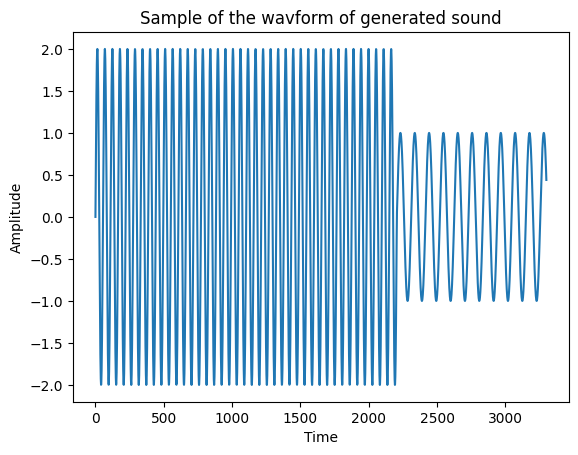

In [13]:
plt.plot(song[:3300])
plt.title("Sample of the wavform of generated sound")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

In [14]:
wavfile.write('octave_song.wav', rate=sample_rate, data=song.astype(np.float32))

Rather than selecting frequencies sequentially, lets use random sampling to draw frequencies from the list.

In [15]:
T = 0.1
n_pixels = 60
frequencies = np.linspace(200, 800, n_pixels)  # Example frequencies
song = np.array([])
octaves = np.array([0.5, 1, 2])
t = np.linspace(0, T, int(T*sample_rate), endpoint=False)

for i in range(n_pixels):
    octave = random.choice(octaves)
    val =  octave * random.choice(frequencies)
    note  = 0.5*np.sin(2*np.pi*val*t)
    song  = np.concatenate([song, note])

display.Audio(song, rate=sample_rate) # load a NumPy array

In [16]:
print("Max note: ", note.max())
print("Min note: ", note.min())

Max note:  0.49999967106831117
Min note:  -0.4999998897486503


### Harmony Dictionary

The harmony dictionary defines various musical intervals, each represented by an abbreviation and described below:

- **U0 (Unison)**: Two notes that are played at the same pitch. This interval has no distance between the notes and is often used to reinforce a melody.

- **ST (Semitone)**: The smallest musical interval in Western music, equivalent to one half step. For example, moving from C to C♯ is a semitone.

- **M2 (Major Second)**: An interval of two semitones. For instance, the interval from C to D is a major second, producing a sound that feels bright and uplifting.

- **m3 (Minor Third)**: An interval of three semitones. The interval from C to E♭ is a minor third, often associated with a darker or more somber sound.

- **M3 (Major Third)**: An interval of four semitones. The interval from C to E is a major third, giving a sense of happiness or brightness.

- **P4 (Perfect Fourth)**: An interval of five semitones. From C to F, this interval is stable and is often used in harmonies.

- **DT (Diatonic Tritone)**: An interval of six semitones. The interval from C to F♯ or B♭ is a tritone, which has a dissonant quality and creates tension.

- **P5 (Perfect Fifth)**: An interval of seven semitones. The interval from C to G is a perfect fifth, commonly used in Western music for its consonant sound.

- **m6 (Minor Sixth)**: An interval of eight semitones. From C to A♭, this interval has a more complex and rich sound, often used in jazz and classical music.

- **M6 (Major Sixth)**: An interval of nine semitones. From C to A, this interval is uplifting and harmonious.

- **m7 (Minor Seventh)**: An interval of ten semitones. The interval from C to B♭ creates a sense of tension and complexity, frequently found in jazz and blues.

- **M7 (Major Seventh)**: An interval of eleven semitones. From C to B, this interval has a dreamy and unresolved quality.

- **O8 (Octave)**: An interval of twelve semitones. From C to the next C, this interval doubles the frequency, resulting in a rich and full sound, often used to signify a return to the tonic.

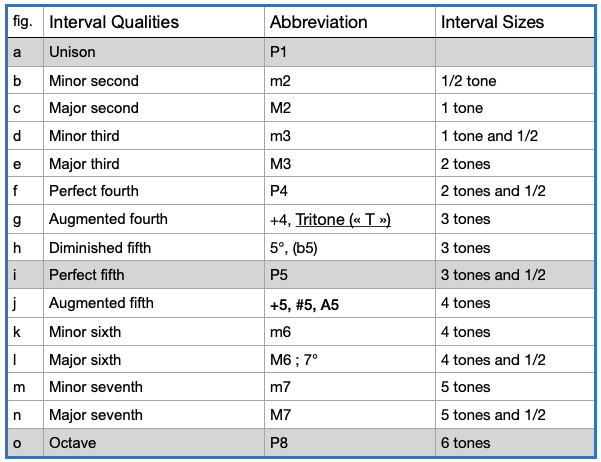

In [17]:
def img2music(
    image: Union[str, np.ndarray], 
    scale: List[float] = None,
    sample_rate: int = 22050, 
    T: float = 0.1, 
    n_pixels: int = 60, 
    use_octaves: bool = True,
    random_pixels: bool = False, 
    harmonize: str = "U0"
) -> Tuple[np.ndarray, pd.DataFrame, np.ndarray]:

    if scale is None:
        scale = [220.00, 246.94, 261.63, 293.66, 329.63, 349.23, 415.30]
                 
    if isinstance(image, str):
        hsv_image = cv2.imread(image, cv2.COLOR_BGR2HSV)
    elif isinstance(image, np.ndarray):
        # Open the image in HSV color format
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    else:
        raise ValidationError(f"Please ensure the image is either a path to a file or a numpy array in BGR format. "
                              f"You provided an image of type: {type(image)}")
    
    # Get shape of image
    height, width, _ = hsv_image.shape  # Fixed shape access
    # Initialize array to contain hues for every pixel in image
    hues = []

    for i in range(height):
        for j in range(width):
            hue = hsv_image[i, j, 0]  # More efficient indexing
            hues.append(hue)

    # Create a DataFrame containing hues and frequencies
    pixels_df = pd.DataFrame(hues, columns=["hues"])
    pixels_df["frequencies"] = pixels_df["hues"].apply(lambda hue: hue2freq(hue, scale))
    frequencies = pixels_df["frequencies"].to_numpy()

    harmony_select = {
        "U0": 1,
        "ST": 16/5,
        "M2": 9/8,
        "m3": 6/5,
        "M3": 5/4,
        "P4": 4/3,
        "DT": 45/32,
        "P5": 3/2,
        "m6": 8/5,
        "M6": 5/3,
        "m7": 9/5,
        "M7": 15/8,
        "O8": 2
    }
    
    harmony_val = harmony_select.get(harmonize, 1)  # Default to 1 if harmonize is not found

    song = np.array([])
    harmony = np.array([])
    octaves = np.array([0.5, 1, 2])
    t = np.linspace(0, T, int(T * sample_rate), endpoint=False)

    # Create a song using numpy arrays
    for k in range(min(n_pixels, len(frequencies))):
        if use_octaves:
            octave = random.choice(octaves)
        else:
            octave = 1
        
        if not random_pixels:
            val = octave * frequencies[k]
        else:
            val = octave * random.choice(frequencies)

        # Generate a note and harmony note
        note = 0.5 * np.sin(2 * np.pi * val * t)
        h_note = 0.5 * np.sin(2 * np.pi * harmony_val * val * t)

        # Concatenate notes into corresponding arrays
        song = np.concatenate([song, note])
        harmony = np.concatenate([harmony, h_note])
        
    return song, pixels_df, harmony

**Test the Functionality**
- Use `n_pixels` to limit the length of the music. The function iterates in a loop up to the minimum value based on `n_pixels` and `frequencies` (where `frequencies` is the flattened version of the image. For an image of size `(H, W, Nchannels)`, the length of `frequencies` is `(Nchannels * H * W)`, which can be large for high-resolution images).

In [ ]:
song, pixels_df, harmony = img2music(
    image=hsv_img, 
    scale=None,
    sample_rate=22050, 
    T=0.1, 
    n_pixels=1434 * 3, 
    use_octaves=True,
    harmonize="U0"
)

display.Audio(song, rate=sample_rate) # load a NumPy array

**Refrenences:**
- [Calculation of note frequencies](https://www.deleze.name/marcel/en/physique/musique/Frequences-en.pdf)
- [Understanding Note Frequnecy Charts](https://producelikeapro.com/blog/note-frequency-chart/)

In [ ]:
def get_piano_notes():
    # White keys are in uppercase, and black keys (sharps) are in lowercase
    octave = ['C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g', 'A', 'a', 'B']
    # Frequency of Note A4
    base_freq = 440
    keys = np.array([x + str(y) for y in range(0, 9) for x in octave])

    # Trim to standard 88 keys
    start = np.where(keys == "A0")[0][0]
    
    end = np.where(keys == "C8")[0][0]
    keys = keys[start:end + 1]

    # Calculate frequencies for each note
    note_freqs = dict(zip(keys, [base_freq * 2 ** ((n - 49) / 12) for n in range(start, end + 1)]))
    note_freqs[''] = 0.0  # Stop note
    
    return note_freqs

def get_sine_wave(frequency, duration, sample_rate=44100, amplitude=4096):
    # Time axis
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = amplitude * np.sin(2 * np.pi * frequency * t)
    return wave

### Music Theory Modes

1. **Aeolian**: Known as the natural minor scale, it conveys a sad, melancholic feel. The intervals are: whole, half, whole, whole, half, whole, whole.

2. **Blues**: A scale integral to blues music, featuring blue notes (flattened notes) for a soulful sound. The intervals are: root, minor third, fourth, diminished fifth, fifth, and minor seventh.

3. **Phrygian**: This minor scale has a unique, exotic character, marked by a flat second degree. The intervals are: half, whole, whole, whole, half, whole, whole.

4. **Chromatic**: Encompassing all twelve pitches within an octave, this scale progresses in half-step intervals, creating a dense, colorful sound.

5. **Diatonic Minor**: Another term for the natural minor scale, highlighting the seven notes that conform to the key signature.

6. **Dorian**: A minor scale with a raised sixth degree, lending it a jazzy or sophisticated quality. The intervals are: whole, half, whole, whole, whole, half, whole.

7. **Harmonic Minor**: This minor scale features a raised seventh degree, producing a strong leading tone that resolves to the tonic, often evoking a Middle Eastern or classical sound.

8. **Lydian**: A major scale with a raised fourth degree, resulting in a dreamy, uplifting character. The intervals are: whole, whole, whole, half, whole, whole, half.

9. **Major**: The classic major scale, known for its bright and happy sound. The intervals are: whole, whole, half, whole, whole, whole, half.

10. **Melodic Minor**: This minor scale ascends with a raised sixth and seventh degree, while descending like the natural minor. It’s frequently utilized in jazz and classical music.

11. **Minor**: Often synonymous with the natural minor scale, it offers a darker tone compared to the major scale.

12. **Mixolydian**: A major scale with a flat seventh degree, imparting a bluesy or folk vibe. The intervals are: whole, whole, half, whole, whole, half, whole.

13. **Natural Minor**: Identical to the Aeolian scale, comprising the notes in a minor key without alterations.

14. **Pentatonic**: A five-note scale that can be either major or minor, widely used across genres for its simplicity and pleasing sound.

### References:
- Diatonic Modes – Open Music Theory: [Link](https://viva.pressbooks.pub/openmusictheory/chapter/diatonic-modes/)
- Modes from Light to Dark Around the Chromatic Circle: [Link](https://www.ethanhein.com/wp/2021/modes-from-light-to-dark-around-the-chromatic-circle/)
- More About Music Theory: [Fitton Music](https://www.fittonmusic.com/writing/melody/scale/dorianandphrygian.html)

In [ ]:
def make_scale(octave: int, 
               key: str, 
               scale: str, 
               make_harmony: str = "U0") -> tuple[list[float], list[float]]:
    """
    Generate frequencies and harmonies for a specified musical scale.

    Parameters:
        octave (int): The octave number for the notes.
        key (str): The starting key of the scale (e.g., 'C', 'D', etc.).
        scale (str): The type of scale to generate (e.g., 'MAJOR', 'MINOR').
        make_harmony (str): The type of harmony to apply (default is "U0").

    Returns:
        tuple: A tuple containing two lists: 
               - Frequencies of the scale notes.
               - Frequencies of the harmony.
    """
    # Load note directory
    note_freqs = get_piano_notes()
    
    # Define tones. Upper case are white keys in piano. Lower case are black keys
    scale_intervals = ['A', 'a', 'B', 'C', 'c', 'D', 'd', 'E', 'F', 'f', 'G', 'g']
    
    # Find index of desired key
    index = scale_intervals.index(key)
    
    # Redefine scale intervals so that scale intervals begin with key
    new_scale = scale_intervals[index:] + scale_intervals[:index]
    
    # Choose the scale
    if scale == 'AEOLIAN':
        scale = [0, 2, 3, 5, 7, 8, 10]
    elif scale == 'BLUES':
        scale = [0, 2, 3, 4, 5, 7, 9, 10, 11]
    elif scale == 'PHRYGIAN':
        scale = [0, 1, 3, 5, 7, 8, 10]
    elif scale == 'CHROMATIC':
        scale = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    elif scale == 'DIATONIC_MINOR':
        scale = [0, 2, 3, 5, 7, 8, 10]
    elif scale == 'DORIAN':
        scale = [0, 2, 3, 5, 7, 9, 10]
    elif scale == 'HARMONIC_MINOR':
        scale = [0, 2, 3, 5, 7, 8, 11]
    elif scale == 'LYDIAN':
        scale = [0, 2, 4, 6, 7, 9, 11]
    elif scale == 'MAJOR':
        scale = [0, 2, 4, 5, 7, 9, 11]
    elif scale == 'MELODIC_MINOR':
        scale = [0, 2, 3, 5, 7, 8, 9, 10, 11]
    elif scale == 'MINOR':
        scale = [0, 2, 3, 5, 7, 8, 10]
    elif scale == 'MIXOLYDIAN':
        scale = [0, 2, 4, 5, 7, 9, 10]
    elif scale == 'NATURAL_MINOR':
        scale = [0, 2, 3, 5, 7, 8, 10]
    elif scale == 'PENTATONIC':
        scale = [0, 2, 4, 7, 9]
    else:
        print('Invalid scale name')
        return []  # Return an empty list if the scale name is invalid

    # Harmony dictionary
    harmony_select = {
        "U0": 1,
        "ST": 16/15,
        "M2": 9/8,
        "m3": 6/5,
        "M3": 5/4,
        "P4": 4/3,
        "DT": 45/32,
        "P5": 3/2,
        "m6": 8/5,
        "M6": 5/3,
        "m7": 9/5,
        "M7": 15/8,
        "O8": 2
    }

    # Get length of scale (i.e., how many notes in scale)
    n_notes = len(scale)

    # Initialize the frequency array
    freqs = []
    harmony = []
    harmony_val = harmony_select[make_harmony]
    for i in range(n_notes):
        note = new_scale[scale[i]] + str(octave)
        freq_to_add = note_freqs.get(note)
        if freq_to_add is not None:
            freqs.append(freq_to_add)
            harmony.append(harmony_val * freq_to_add)
        else:
            print(f"Warning: Note {note} not found in note_freqs.")
    return freqs, harmony

In [ ]:
test_scale, test_harmony = make_scale(3, "a", "HARMONIC_MINOR", make_harmony="m6")

len(test_scale), len(test_harmony)

### Generate the music

In [ ]:
pixel_scale, _ = make_scale(octave=3, key='a', scale='HARMONIC_MINOR')
pixel_song, pixel_df, pixel_harmony = img2music(IMAGE_PATH, 
                                                  pixel_scale, 
                                                  T = 0.2, 
                                                  random_pixels = True)

wavfile.write('pixel_song_harmonic_minor.wav', rate = 44100, data = pixel_song.astype(np.float32))
display.Audio(pixel_song, rate = 22050)

### Merging Song and Harmony
- The `img2music` function produces `song` and `harmony`, both as 1D arrays.
- We can combine these into a 2D array using `np.vstack`.
- To write this 2D array to a `.wav` file, it must be structured as `(Nsamples, Nchannels)`, which is the required format for `scipy.io.wavfile`.
- Finally, we will save the harmonized piece as a single `.wav` file.

In [ ]:
sample_rate = 22050
song_harmony_combined = np.vstack([pixel_song, pixel_harmony])
wavfile.write("song_note_and_harmony_combined.wav", rate=sample_rate, data=song_harmony_combined.T.astype(np.float32))
display.Audio(song_harmony_combined, rate=sample_rate)

### Adding effect in the Music with Pedalboard.

First load the `.wav` files and do some extra manipulation on it using `pedalboard` module from spotify.

#### References:
- [Spotify Pedalboard Documentation](https://spotify.github.io/pedalboard/reference/pedalboard.html)
- [Github repo for pedalboard](https://github.com/spotify/pedalboard)

In [ ]:
from pedalboard import Pedalboard, Chorus, Reverb, Compressor
from pedalboard import Gain, LadderFilter
from pedalboard import Phaser, Delay, PitchShift, Distortion
from pedalboard.io import AudioFile

# read the wav file
with AudioFile('song_note_and_harmony_combined.wav', 'r') as fp:
    audio = fp.read(fp.frames)
    samplerate = fp.samplerate
    num_channels = fp.num_channels
    total_frames = fp.frames

print("=== Audio Information ===".center(30))
print(f"Audio shape: {audio.shape}")
print(f"Sample rate in Audio: {samplerate}")
print(f"Num channels in Audio: {num_channels}")
print(f"Total frames in Audio: {total_frames}")

**Different Controls for Audio**
- **Compressor**: A dynamic range compressor, used to reduce the volume of loud sounds and “compress” the loudness of the signal.
- **Gain**: A gain plugin that increases or decreases the volume of a signal by amplifying or attenuating it by the provided value (in decibels). No distortion or other effects are applied.
- **Chorus**: A basic chorus effect.(This typically applies a modulation effect to thicken the sound by simulating multiple instruments playing together.)
- **LadderFilter**: A multi-mode audio filter based on the classic Moog synthesizer ladder filter, invented by Dr. Bob Moog in 1968. [See more about Sound of the Moog Ladder Filter](https://www.uaudio.com/blog/moog-ladder-filter)
- **Phaser**: A 6 stage phaser that modulates first order all-pass filters to create sweeping notches in the magnitude frequency response.
- **Reverb**: A simple reverb effect. Uses a simple stereo reverb algorithm, based on the technique and tunings used in [FreeVerb](https://ccrma.stanford.edu/~jos/pasp/Freeverb.html).

In [ ]:
# Create a Pedalboard object containing multiple plugins
board = Pedalboard([
    Compressor(threshold_db=-100, ratio=25),
    Gain(gain_db=150),
    Chorus(),
    LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=900),
    Phaser(),
    Reverb(room_size=0.5),
])

# Run the audio through the Pedalboard object
modified_audio = board(audio, samplerate)

# Write the audio back to a WAV file
with AudioFile('processed_song_and_harmony_combined.wav', 'w', samplerate, modified_audio.shape[0]) as f:
    f.write(modified_audio)

display.Audio("processed_song_and_harmony_combined.wav")

### Using Librosa for Audio Processing

- Librosa is a package used to perform various operations on sound data.
- In this context, we use it to convert frequencies into **notes** and **MIDI numbers**.

In [ ]:
pixel_df.head(2)

In [ ]:
import librosa

# convert frequency yo a  note
pixel_df["notes"] = pixel_df.apply(lambda row: librosa.hz_to_note(row["frequencies"]),
                                  axis=1)
# convert note to a midi number
pixel_df["midi_number"] = pixel_df.apply(lambda row: librosa.note_to_midi(row["notes"]),
                                        axis=1)

pixel_df.head(2)

In [ ]:
# convert the midi_number column to a numpy array
midi_number = pixel_df["midi_number"].to_numpy()
print("Total midi number generated: ", len(midi_number))

### Generate a MIDI File for a Given Song

Now that we have the `notes` and their corresponding `midi_number` obtained from the music, we can create a MIDI file that can be used to generate sheet music.

- Note that `music21` does not support the `♯` accidental type. Instead, the `#` symbol should be used for sharps in `music21`.
- As the number of total notes can become large, we will construct the MIDI file using only one channel. (While we can also create a MIDI file with multiple channels, we will focus on a single channel here.)
- We will exclude adjacent duplicate notes to reduce the overall number of notes and limit the MIDI file to at most 500 elements.

In [ ]:
notes_array = pixel_df["notes"].to_numpy()

# Create a new list to hold the filtered elements
filtered_notes = []

# Loop through the original array
for element in notes_array:
    # Only append if the list is empty or the last element is different
    if not filtered_notes or element != filtered_notes[-1]:
        filtered_notes.append(element)

# Convert back to a NumPy array if needed
filtered_notes = np.array(filtered_notes)

print("Sampled filtered: ", filtered_notes)
print("Total filtered notes: ", len(filtered_notes))

In [ ]:
import music21 as m21
from music21 import stream, note, meter, tempo

from tqdm.auto import tqdm

# Create a music21 stream
midi_stream = stream.Stream()

# Set the tempo
bpm = 120
midi_stream.append(tempo.MetronomeMark(number=bpm))

# Define the duration of each note
duration = 0.5
total_duration = 12
total_beats = (total_duration * bpm) / 60  # Convert the seconds to beats

# Generate MIDI notes
for element in tqdm(filtered_notes):
    pitch = element.replace('♯', "#")
    # Create a note from the pitch
    midi_note = note.Note(pitch) 
    midi_note.quarterLength = duration
    midi_stream.append(midi_note)

In [ ]:
# Save the MIDI file
midi_stream.write("midi", fp="freq_to_midi_processed.mid")

### Play the `MIDI` file

In [ ]:
from midi_player import MIDIPlayer
from midi_player.stylers import basic, cifka_advanced

midi_file = 'freq_to_midi_processed.mid'

MIDIPlayer(midi_file, 160, styler=cifka_advanced, title='My Player')

### 😊😊 Happy coding